<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF-395 / 477 / 577 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Andrea Freire - Francisco Sáez </H3>
<hr style="height:2px;border:none"/>

## 4. GAN para MNIST

Probablemente uno de los desarrollos recientes del área de las redes neuronales más interesantes son las GAN o _Generative Adversarial Networks_. Estas han deslumbrado al mundo los últimos años generando resultados inesperados, como los llamados _deep fakes_ (https://www.youtube.com/watch?v=25GjijODWoI&ab_channel=Borked), caras que no existen generadas artificialmente, entre muchas otras aplicaciones de las cuales las más creativas y divertidas son ampliamente divulgadas. Estos resultados nos dan cuenta que estas redes cuando son implementadas correctamente tienen la habilidad de realizar tareas muy específicas logrando desempeño que logran incluso en algunos casos engañar a observadores humanos.

Dependiendo del problema que uno quiera resolver las GAN no requieren datos etiquetados. Esto lo logran gracias a su estructura adversarial, es decir, donde simultaneamente se entrenan dos redes, una especializada en generar datos y otra red especializada en discriminar datos verdaderos de datos falsos, en su configuración más simple al mano. En esta parte de la tarea deberan generar una red de este tipo que genere dígitos que aparenten ser hechos a meno. Para esto utilizaremos las imágenes de entrenamiento del dataset MNIST que ya conocen.

## 4.a) Primera GAN

El código siguiente contiene todos los ingredientes para entrenar una red GAN, se encuentra áltamente comentada para su entendimiento. Ustede deberá incluir funcionalidades al código, no incluya aún ninguna mejora a la arquitectura de las redes, esto se verá en el ítem 4.c). Las funcionalidades que debe añadir son las siguientes:

i) Imprimir alguna medida del desempeño tanto del generador como del discriminador (por ejemplo, F1-score, precision and recall o accuracy) a lo largo del entrenamiento. ¿Variaciones en esta medida representan mejoras en nuestra red?

ii) Añadir gráficos de las entradas de data real con un título que indique la clasificación que está dando el discriminador a cada una de estas imágenes (FALSA | REAL). El código entregado grafica tan solo las imágenes que genera el generador y la etiqueta que está dando el discriminador (FALSA | REAL).

**Comentarios:**
- Variaciones en la métrica elegida no representa necesariamente que la red vaya mejorando. Esto se debe a que, por ejemplo, no se esté utilizando la métrica adecuada o dado que una GAN esté formada por dos redes por separada  y los entrenamientos se realizan de forma independiente esto afecta en el desempeño de la red. Dado que se espera que la actualización de los pesos de la red del discriminador sea más reiterativo que la actualización de la red del generador. 

In [1]:
# Paquetes a utilizar
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Activation

In [2]:
# Dataset
(x,_),(_,_) = mnist.load_data()
x = x.reshape((-1,28,28,1)).astype(np.float32)
x = x/255

11493376/11490434 [==============================] - 0s 0us/step


In [19]:
# Discriminator
dis_net = Sequential()
dis_net.add(Conv2D(3, 3, strides = 2, input_shape = x.shape[1:],
                   padding = 'same'))     # Recibe como entrada imágenes del generador y del dataset.                     
dis_net.add(Flatten())                    # Pasar de Conv a capa densa                                                   
dis_net.add(Dense(1, activation = 'sigmoid',
                  use_bias = False))      # La salida estará entre 0 y 1.

# Generator
gen_net     = Sequential()
noise_size  = 50
gen_net.add(Dense(7*7*10, input_shape = [noise_size])) # Generator utiliza como entrada ruido
gen_net.add(Reshape((7,7,10)))                         # Transforma la salida de la red densa unidimensional a tridimensional
gen_net.add(UpSampling2D())                            # Pasar de (7,7,10) a (14,14,10)
gen_net.add(Conv2D(32,5, padding = 'same'))            # Transforma la data desde (14,14,10) a (14,14,32)
gen_net.add(UpSampling2D())                            # Pasar de (14,14,32) a (28,28,32)
gen_net.add(Conv2D(1,6, padding = 'same',
                   activation = 'sigmoid'))            # Salida (28,28,1)

# Se compila el generador, se agrega una red auxiliar para entrenarla aparte del generator
discriminator = Sequential()     
discriminator.add(dis_net)
discriminator.compile(loss = 'binary_crossentropy', 
                      optimizer = Adam(lr=0.0002, beta_1=0.5),
                      metrics = ['accuracy'])          # Se compila con Binary CrossEntropy

# Crear red GAN con generator y discriminator en serie
GAN = Sequential()
GAN.add(gen_net)            # Se agrega el generator

for layer in dis_net.layers:
  layer.trainable = False   # Capa no entrenable, dado que discriminator se entrena con data real

GAN.add(dis_net)            # Se añade las capas ya modificadas para no ser entrenadas
GAN.compile(loss = 'binary_crossentropy',
            optimizer = Adam(lr=0.0002, beta_1=0.5),
            metrics = ['accuracy'])    

In [20]:
batch_size = 128     
plt.rcParams['figure.figsize'] = [20,4]
loss_dis = []
acc_dis  = []
loss_GAN = []
acc_GAN  = []


for epoch in range(20): 
  loss_batch_dis = []
  acc_batch_dis  = []
  loss_batch_GAN = []
  acc_batch_GAN  = []
  for batch in range(int(x.shape[0]/batch_size)):

    # Train discriminator
    ix      = np.random.randint(0, x.shape[0], batch_size)        # Ix para samplear imágenes del dataset
    x_real  = x[ix]                                               # Seleccionar imágenes
    noise   = np.random.rand(noise_size*batch_size)               # Ruido según el tamaño de la entrada
    noise   = noise.reshape((batch_size, noise_size))             # Reshape (batch_size,noise_size)
    x_false = gen_net.predict(noise)                              # Generar imágenes según el ruido
    y_real  = np.ones((batch_size,1))                             # Etiqueta real 
    y_false = np.zeros((batch_size,1))                            # Etiquetas fake
    x_train = np.concatenate((x_real,x_false))                    # x_tr -> img real + img fake
    y_train = np.concatenate((y_real,y_false))                    # y_tr -> label real + label fake
    response_dis = discriminator.train_on_batch(x_train, y_train) # Train discriminator
    loss_batch_dis.append(response_dis[0])
    acc_batch_dis.append(response_dis[1])

    # Train generator
    noise2  = np.random.rand(noise_size*batch_size)               # Genera ruido
    noise2  = noise2.reshape((batch_size, noise_size))            # Reshape (batch_size,noise_size)
    response_gen = GAN.train_on_batch(noise2, 
                                      np.ones((batch_size,1)))
    loss_batch_GAN.append(response_gen[0])
    acc_batch_GAN.append(response_gen[1])
    
    if batch%(200) == 0:

      plt.suptitle('Generator generated images', y=1.2, size = 22)
      for i in range(10):
        plt.subplot(2, 5, 1+i)
        plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(discriminator.predict(x_false[i:i+1, :, :, :])[0,0],0))])
        plt.axis('off')
        plt.imshow(x_false[i,:,:,0], cmap = 'gray_r')
      plt.tight_layout()
      plt.show()
      print('-'*120)

      plt.suptitle('Real images', y = 1.2, size = 22)
      for i in range(10):
        plt.subplot(2,5,1+i)
        plt.title('Discriminator says:\n'+["Fake", "Real"][int(np.round(discriminator.predict(x_real[i:i+1, :, :, :])[0,0],0))])
        plt.axis('off')
        plt.imshow(x_real[i,:,:,0], cmap = 'gray_r')
      plt.tight_layout()
      plt.show()
      print('-'*120)
  
  # Discriminator
  loss_dis.append(np.mean(loss_batch_dis))
  acc_dis.append(np.mean(acc_batch_dis))

  # GAN
  loss_GAN.append(np.mean(loss_batch_GAN))
  acc_GAN.append(np.mean(acc_batch_GAN))

Output hidden; open in https://colab.research.google.com to view.

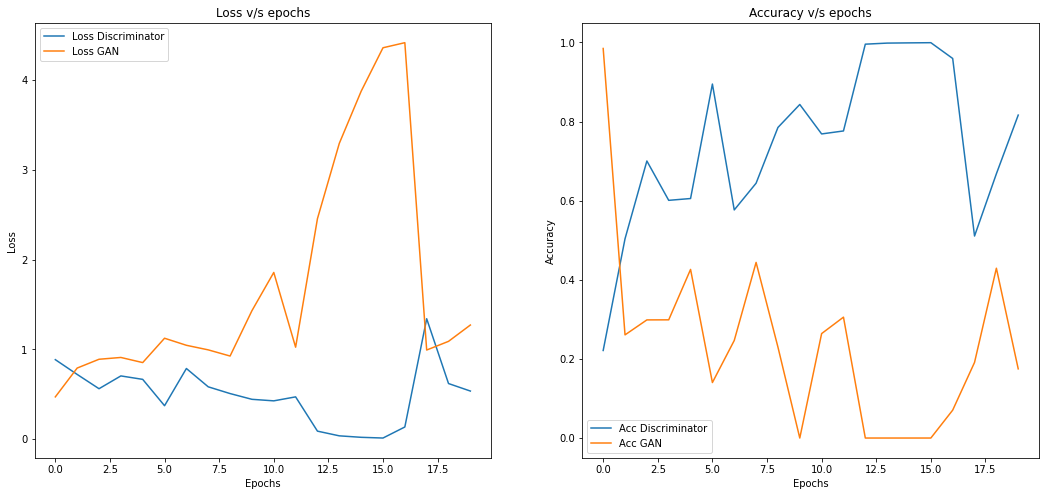

In [21]:
## Gráficos
plt.rcParams["figure.figsize"] = [18,8]
plt.subplot(1,2,1)
plt.plot(loss_dis, label = 'Loss Discriminator')
plt.plot(loss_GAN, label = 'Loss GAN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss v/s epochs')

plt.subplot(1,2,2)
plt.plot(acc_dis, label = 'Acc Discriminator')
plt.plot(acc_GAN, label = 'Acc GAN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy v/s epochs')

plt.show()

## 4.b) Mejora de GAN

Utilizando el código modificado en el punto 4.b y lo aprendido durante el ramo. Modifique la arquitectura de la red neuronal a modo de obtener imágenes fake convincentes. Adicionalmente responda/comente según lo que observa durante el entrenamiento de la red neuronal.

* Explicar el comportamiento de la evolución de ambos desempeños y por qué no necesariamente esos valores representan que la red alcance su cometido.
* Describir, teórica o prácticamente, que ocurriría si la red generadora no pudiera por algún motivo (divergencia en entrenamiento, excesivo _underfitting_, etc) generar imágenes razonables. 
* Describir la contraparte de lo que ocurriría si la red discriminadora no pudiera aprender a diferenciar imágenes reales del ruido aleatorio.

Una vez teniendo una red entrenada a completitud, muestre varias imágenes generadas. ¿Se logra obtener imágenes convincentes?. Igualmente con la red entrenada, guarde el ruido aleatorio que origina dos números reconocibles distintos. ¿Qué ocurre si vemos las imágenes generadas por el generador al entregarle el vector del promedio entre los dos puntos?

**Comentarios:**
- Se puede ver en los gráficos expuesto en esta sección, que el desempeño en el discriminador es mucho mejor que el caso del generador. Esto se puede deber a que el discriminador tiende a entrenarse de mejor forma que el generador. Por ende, alcanza un buen desempeño. Por su parte, el generador dado que, quizás la métrica utilizada no es la correspondiente, se ve que tuviera un mal desempeño. En este caso no es correcto dado que la red generadora si puede representar o generar imágenes convincentes y muy cercanas a la data original.
- Si la red generadora no tiene la arquitectura necesaria para poder generar data convincente, a medida que pasan los epochs ésta predicirá imágenes sin sentido respecto a las imágenes reales. Es lo que pasa en la parte a) de este problema y por ende, el desempeño será muy malo.
- Si el discriminador no puede diferenciar se puede argumentar que, o las imágenes generadas son muy buenas o el discriminador no ha sido entrenado de forma correcta por lo que sería buena opción cambiar la arquitectura.

In [30]:
# Discriminator
dis_net = Sequential()

# Primera Capa
dis_net.add(Conv2D(filters=64, kernel_size = 5, strides= 2,
                   padding='same', input_shape=x.shape[1:], 
                   activation = LeakyReLU(alpha=0.2)))
dis_net.add(Dropout(0.4))

# Segunda Capa
dis_net.add(Conv2D(filters=128, kernel_size=5, strides= 2,
                   padding= 'same', 
                   activation = LeakyReLU(alpha=0.2)))
dis_net.add(Dropout(0.4)) 

dis_net.add(Conv2D(filters=256, kernel_size = 5, strides=2,
                   padding='same', 
                   activation = LeakyReLU(alpha=0.2)))
dis_net.add(Dropout(0.4)) 

dis_net.add(Conv2D(filters=512, kernel_size=5, strides=1, 
                   padding= 'same', 
                   activation = LeakyReLU(alpha=0.2)))
dis_net.add(LeakyReLU())
dis_net.add(Dropout(0.4)) 

# Capa Final
dis_net.add(Flatten())                                                                              
dis_net.add(Dense(1, activation = 'sigmoid'))     

In [24]:
dis_net.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 512)       

In [31]:
# Generator
gen_net     = Sequential()
noise_size  = 100

# Primera Capa
gen_net.add(Dense(7*7*256, input_shape = [noise_size])) # Generator utiliza como entrada ruido
gen_net.add(BatchNormalization(momentum=0.9))
gen_net.add(Activation('relu'))
gen_net.add(Reshape((7,7,256)))                         # Transforma la salida de la red densa unidimensional a tridimensional
gen_net.add(Dropout(0.5))

# Segunda Capa     
gen_net.add(UpSampling2D())                           
gen_net.add(Conv2DTranspose(128, 5, padding='same'))
gen_net.add(BatchNormalization(momentum=0.9))
gen_net.add(Activation('relu'))

# Tercera Capa
gen_net.add(UpSampling2D())    
gen_net.add(Conv2DTranspose(64, 5, padding='same'))
gen_net.add(BatchNormalization(momentum=0.9))
gen_net.add(Activation('relu'))

# Cuarta Capa
gen_net.add(Conv2DTranspose(32, 5, padding='same'))
gen_net.add(BatchNormalization(momentum=0.9))
gen_net.add(Activation('relu'))

# Capa Salida                       
gen_net.add(Conv2D(1,5, padding = 'same',
                   activation = 'sigmoid'))            # Salida (28,28,1)    


In [25]:
gen_net.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
activation (Activation)      (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)     

In [32]:
# Se compila el generador, se agrega una red auxiliar para entrenarla aparte del generator
discriminator = Sequential()     
discriminator.add(dis_net)
discriminator.compile(loss = 'binary_crossentropy', 
                      optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10),
                      metrics = ['accuracy'])          # Se compila con Binary CrossEntropy

# Crear red GAN con generator y discriminator en serie
GAN = Sequential()
GAN.add(gen_net)            # Se agrega el generator

for layer in dis_net.layers:
  layer.trainable = False   # Capa no entrenable, dado que discriminator se entrena con data real

GAN.add(dis_net)            # Se añade las capas ya modificadas para no ser entrenadas
GAN.compile(loss = 'binary_crossentropy',
            optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8),
            metrics = ['accuracy'])    

In [33]:
batch_size = 256
plt.rcParams['figure.figsize'] = [20,4]
loss_dis_b = []
acc_dis_b  = []
loss_GAN_b = []
acc_GAN_b  = []

for epoch in range(20): 
  print('\n Epoch: ',epoch+1)
  loss_batch_dis_b = []
  acc_batch_dis_b  = []
  loss_batch_GAN_b = []
  acc_batch_GAN_b  = []
  for batch in range(int(x.shape[0]/batch_size)):

    # Train discriminator
    ix      = np.random.randint(0, x.shape[0], batch_size)        # Ix para samplear imágenes del dataset
    x_real  = x[ix]                                               # Seleccionar imágenes
    noise   = np.random.uniform(-1.0, 1.0, 
                               size=[batch_size, 100])            # Ruido según el tamaño de la entrada
    noise   = noise.reshape((batch_size, noise_size))             # Reshape (batch_size,noise_size)
    x_false = gen_net.predict(noise)                              # Generar imágenes según el ruido
    y_real  = np.ones((batch_size,1))                             # Etiqueta real 
    y_false = np.zeros((batch_size,1))                            # Etiquetas fake
    x_train = np.concatenate((x_real,x_false))                    # x_tr -> img real + img fake
    y_train = np.concatenate((y_real,y_false))                    # y_tr -> label real + label fake
    response_dis = discriminator.train_on_batch(x_train, y_train) # Train discriminator
    loss_batch_dis_b.append(response_dis[0])
    acc_batch_dis_b.append(response_dis[1])
    

    # Train generator
    noise2  = np.random.rand(noise_size*batch_size)               # Genera ruido
    noise2  = noise2.reshape((batch_size, noise_size))            # Reshape (batch_size,noise_size)
    response_gen = GAN.train_on_batch(noise2, 
                                      np.ones((batch_size,1)))
    loss_batch_GAN_b.append(response_gen[0])
    acc_batch_GAN_b.append(response_gen[1])
    
    if batch%(200) == 0:

      plt.suptitle('Generator generated images', y=1.2, size = 22)
      for i in range(10):
        plt.subplot(2, 5, 1+i)
        plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(discriminator.predict(x_false[i:i+1, :, :, :])[0,0],0))])
        plt.axis('off')
        plt.imshow(x_false[i,:,:,0], cmap = 'gray_r')
      plt.tight_layout()
      plt.show()
      print('-'*120)

      plt.suptitle('Real images', y = 1.2, size = 22)
      for i in range(10):
        plt.subplot(2,5,1+i)
        plt.title('Discriminator says:\n'+["Fake", "Real"][int(np.round(discriminator.predict(x_real[i:i+1, :, :, :])[0,0],0))])
        plt.axis('off')
        plt.imshow(x_real[i,:,:,0], cmap = 'gray_r')
      plt.tight_layout()
      plt.show()
      print('-'*120)

  # Discriminator
  loss_dis_b.append(np.mean(loss_batch_dis_b))
  acc_dis_b.append(np.mean(acc_batch_dis_b))

  # GAN
  loss_GAN_b.append(np.mean(loss_batch_GAN_b))
  acc_GAN_b.append(np.mean(acc_batch_GAN_b))

Output hidden; open in https://colab.research.google.com to view.

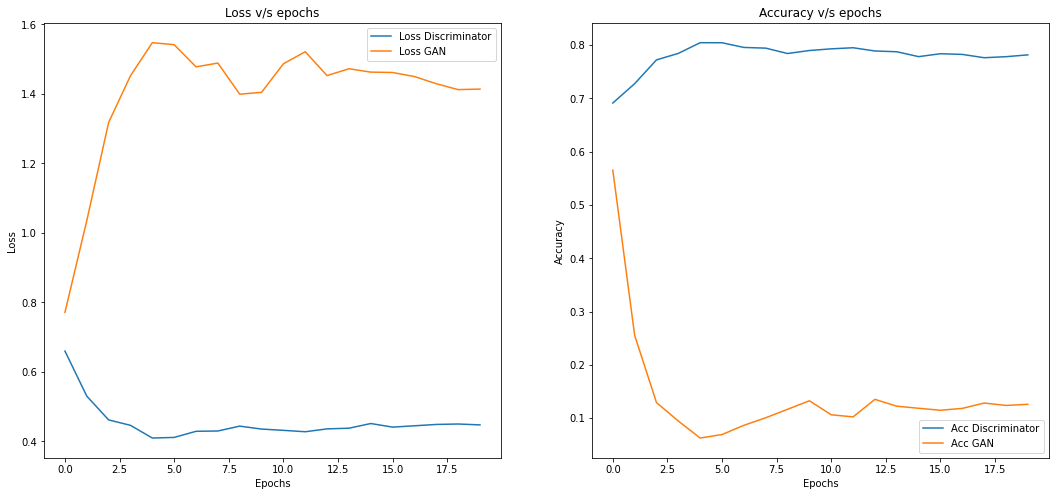

In [34]:
## Gráficos
plt.rcParams["figure.figsize"] = [18,8]
plt.subplot(1,2,1)
plt.plot(loss_dis_b, label = 'Loss Discriminator')
plt.plot(loss_GAN_b, label = 'Loss GAN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss v/s epochs')

plt.subplot(1,2,2)
plt.plot(acc_dis_b, label = 'Acc Discriminator')
plt.plot(acc_GAN_b, label = 'Acc GAN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy v/s epochs')

plt.show()

**Comentarios:**
- Se puede ver que al pasar pocas epochs, la red generadora si puede generar imágenes bastantes semejantes al data set original. Esto no se ve reflejado en los gráficos de las métricas para la red GAN.
- Además, se puede destacar que la arquitectura de la red discriminadora y de la generadora son redes convolucionales profundas con técnicas de dropout, funciones de activación y batch normalization. Por lo que se concluye que cuando se tiene un problema de imágenes y se desee resolver mediante una GAN, se debe constuir una CNN para ambas redes como si estas fueran separadas e incluir todas las técnicas necesarias para lograr gran desempeño en la generación de estas imágenes.

In [74]:
# Generación de Ruido 1 
np.random.seed(1)
noise_1   = np.random.uniform(-1.0, 1.0,size=[1, 100])      
noise_1   = noise_1.reshape((1, noise_size))             
x_false_1 = gen_net.predict(noise_1) 

# Generación de Ruido 2
np.random.seed(2)
noise_2   = np.random.uniform(-1.0, 1.0,size=[1, 100])      
noise_2   = noise_2.reshape((1, noise_size))             
x_false_2 = gen_net.predict(noise_2) 

# Promedio de ruido
noise_mean = np.mean((noise_1,noise_2),axis=0)
x_false_mean = gen_net.predict(noise_mean)

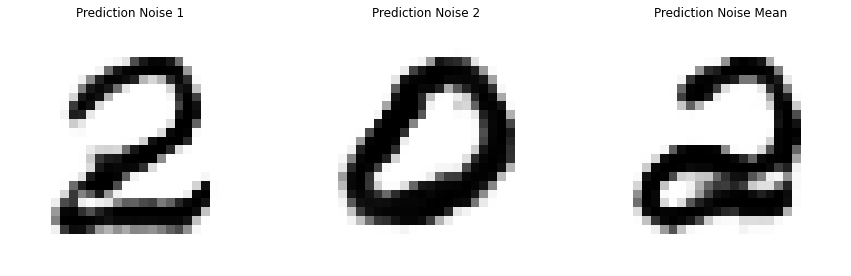

In [81]:
# Gráfico 
plt.rcParams["figure.figsize"] = [15,5]
plt.subplot(1,3,1)
plt.imshow(x_false_1[0,:,:,0], cmap = 'gray_r')
plt.axis('off')
plt.title('Prediction Noise 1')

plt.subplot(1,3,2)
plt.imshow(x_false_2[0,:,:,0], cmap = 'gray_r')
plt.axis('off')
plt.title('Prediction Noise 2')

plt.subplot(1,3,3)
plt.imshow(x_false_mean[0,:,:,0], cmap = 'gray_r')
plt.axis('off')
plt.title('Prediction Noise Mean')

plt.show()

**Comentario:**
- La primer imagen corresponde a la predicción de un ruido que se genera de forma uniforme y esta claramente corresponde al número 2. Lo mismo para la imagen 2, la cual corresponde al número 0. 
- Se puede ver que, una vez entrenada, el generador al recibir el ruido si entrega imágenes muy convincentes y por ende, aprendió de forma correcta la distribución de la data real.
- Por último, el promedio de estos ruidos y su respectiva predicción entrega una combinación de estos valores, es decir, del número 2 y 0. Donde se puede diferenciar un número 2, pero que está influenciado por la forma del número 0.

## Pregunta **Bonus**

* Proponga o investigue como realizaría las siguientes tareas:
    * A partir de una base de datos de imagenes RGB, entrenar una GAN que genere imágenes a color convincentes a partir de imagenes en blanco y negro, es decir que deduzca el color a partir de imagenes en blanco y negro.
    * A partir de una base de datos de cuadros de paisajes reales y las fotos correspondientes al cuadro, entrenar una GAN que permita transformar fotografias a cuadros y viceversa (puede utilizar más de 2 redes)
    * Proponga un problema que les parezca interesante y una estructura de GAN que le permitiría resolverlo

**Respuesta:**
- Para encontrar una arquitectura que apartir de imágenes RGB, pueda generar imágenes a color convincentes a partir de imágenes blanco y negro, es necesario crear una arquitectura de una red neuronal convolucional tanto para el generador como para el discriminador. Los hiperparámetros dependeran del dataset a utilizar, pero con la forma de implementar una GAN propuesta en 4.b) se puede lograr este cometido, por ejemplo, para el dataset CIFAR-10.
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
- De forma similar, se puede realizar la tarea de cuadros de paisajes mediante la creación de una arquitectura de red neuronal convolucional que permita extraer toda la información contenida en esas imágenes. A diferencia de las arquitecturas de esta tarea, el target corresponde a imágenes, por lo que se necesita utilizar una red acorde a esta necesidad. https://arxiv.org/pdf/1611.07004.pdf
- Una de las aplicaciones de una red GAN es poder, por ejemplo, generar nuevas poses, como es el caso del ejemplo mostrado en el enunciado. A partir de imágenes y con la ayuda de una red GAN se puede generar nuevas poses. Por ejemplo, si se tiene la imágen de una persona levantando la pierna izquierda, con la ayuda de la red se puede obtener la misma persona levantando la pierna derecha. https://openaccess.thecvf.com/content_cvpr_2018/papers/Siarohin_Deformable_GANs_for_CVPR_2018_paper.pdf
- Otros ejemplos se pueden encontrar en https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/
